# This notebook contains code to compare KMeans Clustering and Hierarchical clustering to determine which is more effective and some initial concepts on Cluster Drift

- The accompanying Medium article can be found at 

In [21]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# %#matplotlib inline

In [22]:
df_raw = pd.read_csv("data/Sample_Superstore_v2.csv", encoding="latin1")

In [23]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

In [24]:
df_raw.describe(include=["O"])

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Region,Product ID,Category,Sub-Category,Product Name
count,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994
unique,5009,1237,1334,4,793,793,3,1,531,49,4,1862,3,17,1850
top,CA-2017-100111,9/5/2016,12/16/2015,Standard Class,WB-21850,William Brown,Consumer,United States,New York City,California,West,OFF-PA-10001970,Office Supplies,Binders,Staple envelope
freq,14,38,35,5968,37,37,5191,9994,915,2001,3203,19,6026,1523,48


In [25]:
df_key_fields = df_raw[["Customer ID", "Sub-Category", "Sales"]].copy()

In [26]:
df_cust_sales = df_key_fields.pivot_table(
    values="Sales", columns="Sub-Category", aggfunc=np.sum, index="Customer ID"
).reset_index()

In [27]:
df_cust_sales.head(10)

Sub-Category,Customer ID,Accessories,Appliances,Art,Binders,Bookcases,Chairs,Copiers,Envelopes,Fasteners,Furnishings,Labels,Machines,Paper,Phones,Storage,Supplies,Tables
0,AA-10315,41.720,415.92,NaN,685.108,NaN,NaN,NaN,NaN,2.304,14.560,NaN,NaN,14.940,431.976,26.960,3930.072,NaN
1,AA-10375,649.950,NaN,5.248,74.004,NaN,NaN,NaN,NaN,NaN,28.400,NaN,NaN,80.080,116.980,101.728,NaN,NaN
2,AA-10480,479.970,NaN,8.640,NaN,NaN,NaN,NaN,NaN,NaN,27.460,NaN,NaN,108.522,209.970,508.110,NaN,447.840
3,AA-10645,NaN,NaN,5.280,113.940,1279.165,2347.888,NaN,43.96,NaN,123.660,NaN,NaN,119.280,354.682,699.080,NaN,NaN
4,AB-10015,NaN,NaN,17.940,NaN,341.960,48.712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,221.980,255.564,NaN,NaN
5,AB-10060,195.740,160.32,NaN,4404.216,NaN,449.568,NaN,NaN,NaN,127.880,NaN,NaN,353.106,NaN,NaN,27.930,2036.860
6,AB-10105,129.400,NaN,23.640,11068.910,NaN,NaN,NaN,NaN,NaN,886.840,3.69,287.91,NaN,1287.000,393.016,NaN,393.165
7,AB-10150,571.930,NaN,158.656,49.632,NaN,NaN,NaN,NaN,NaN,15.992,NaN,NaN,145.208,NaN,NaN,25.292,NaN
8,AB-10165,212.928,NaN,125.408,128.544,NaN,37.296,NaN,NaN,NaN,94.200,NaN,NaN,211.232,NaN,304.230,NaN,NaN
9,AB-10255,50.400,NaN,19.680,15.420,NaN,NaN,479.984,NaN,17.050,18.920,NaN,NaN,265.988,2.970,27.440,16.680,NaN


In [28]:
df_cust_sales.fillna(0, inplace=True)

In [29]:
df_cust_sales.iloc[:, 1:] = df_cust_sales.iloc[:, 1:].applymap(lambda x: np.log(x + 1))

In [30]:
df_cust_sales.fillna(0.0, inplace=True)

In [31]:
df_for_pca = df_cust_sales.iloc[:, 1:].copy()

## Clustering by Employing K Means

In [32]:
pca = PCA()
df_pca = pca.fit_transform(df_for_pca)
exp_var = np.cumsum(pca.explained_variance_ratio_)

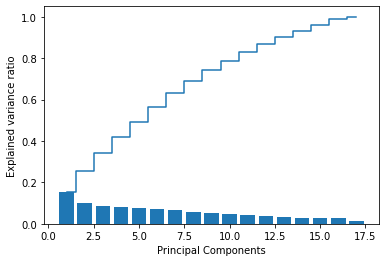

In [33]:
plt.bar(range(1, df_pca.shape[1] + 1), pca.explained_variance_ratio_, align="center")
plt.step(
    range(1, df_pca.shape[1] + 1), np.cumsum(pca.explained_variance_ratio_), where="mid"
)
plt.ylabel("Explained variance ratio")
plt.xlabel("Principal Components")

plt.show()

In [34]:
# Showing the breakdown of the components

loadings = pd.DataFrame(pca.components_[0:12, :], columns=df_for_pca.columns)

loadings.index.rename("Principal Component", inplace=True)

print(loadings)

Sub-Category         Accessories  Appliances       Art   Binders  Bookcases  \
Principal Component                                                           
0                       0.299488    0.215222  0.130083  0.194586   0.113307   
1                       0.291298    0.021033 -0.016075  0.072558  -0.039979   
2                       0.015721   -0.036152 -0.056943  0.087310  -0.283600   
3                      -0.297868   -0.335876 -0.093622 -0.145448   0.149217   
4                      -0.681273   -0.011905 -0.012593 -0.061011   0.171333   
5                      -0.319342    0.584014 -0.006413  0.046002  -0.656444   
6                      -0.152519    0.586203  0.107409  0.140265   0.632479   
7                      -0.173497   -0.315009 -0.065533  0.429541  -0.014539   
8                       0.205509   -0.040925  0.068308  0.145188  -0.012197   
9                       0.140604    0.081405 -0.079482 -0.690488   0.057778   
10                      0.134558    0.065944  0.2509

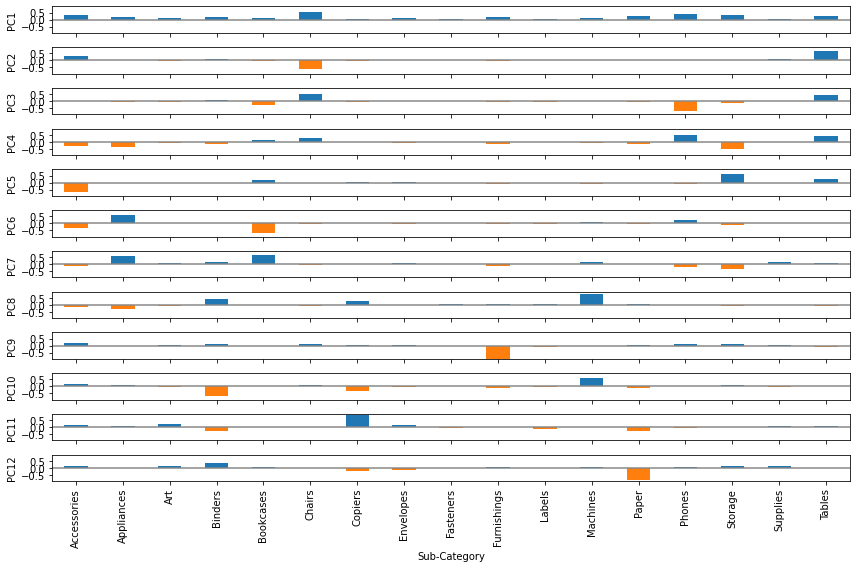

In [35]:
# Graphical Representation of the values of each Principal Component

maxPC = 1.01 * loadings.loc[0:12, :].abs().to_numpy().max()

f, axes = plt.subplots(12, 1, figsize=(12, 8), sharex=True)

for i, ax in enumerate(axes):
    pc_loadings = loadings.loc[i, :]
    colors = ["C0" if l > 0 else "C1" for l in pc_loadings]
    ax.axhline(color="#888888")
    pc_loadings.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f"PC{i+1}")
    ax.set_ylim(-maxPC, maxPC)

plt.tight_layout()
plt.show()

In [36]:
# Masking based on 90% variance ratio explained
exp_var = np.ma.MaskedArray(exp_var, exp_var < 0.9)
exp_var

masked_array(data=[--, --, --, --, --, --, --, --, --, --, --, --,
                   0.9012439180276831, 0.9315184091330488,
                   0.9609887384148906, 0.9866734590101903, 1.0],
             mask=[ True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True, False, False, False, False,
                   False],
       fill_value=1e+20)

In [37]:
# Find number of components based on 90% variance ratio explained
n_components = np.argmin(exp_var)
print(n_components)

12


In [38]:
pca_components = PCA(n_components=n_components)

In [39]:
pca_arr = pca_components.fit_transform(df_for_pca)

C:\Users\wengz\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\wengz\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\wengz\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\wengz\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\cluster\_kmeans.p

C:\Users\wengz\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


29


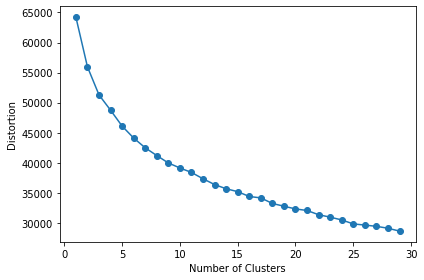

In [40]:
distortions = []
for i in range(1, 30):
    km = KMeans(n_clusters=i, init="k-means++", n_init=10, max_iter=300, random_state=0)
    km.fit(pca_arr)
    distortions.append(km.inertia_)

print(len(distortions))
plt.plot(range(1, len(distortions) + 1), distortions, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("Distortion")
plt.tight_layout()
plt.show()

In [41]:
km_final = KMeans(
    n_clusters=25, init="k-means++", n_init=10, max_iter=300, random_state=0
)
results = km_final.fit_predict(pca_arr)

C:\Users\wengz\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [42]:
unique_elements, counts_elements = np.unique(results, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24]
 [38 24 35 29 38 33 33 33 34 22 34 17 42 37 28 30 23 36 25 41 41 28 26 31
  35]]


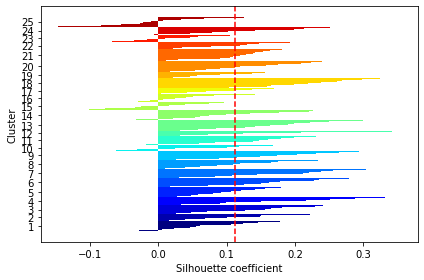

In [43]:
from matplotlib import cm
from sklearn.metrics import silhouette_samples

cluster_labels = np.unique(results)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(pca_arr, results, metric="euclidean")
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[results == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(
        range(y_ax_lower, y_ax_upper),
        c_silhouette_vals,
        height=1.0,
        edgecolor="none",
        color=color,
    )

    yticks.append((y_ax_lower + y_ax_upper) / 2.0)
    y_ax_lower += len(c_silhouette_vals)

silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--")

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel("Cluster")
plt.xlabel("Silhouette coefficient")

plt.tight_layout()
# plt.savefig('figures/10_04.png', dpi=300)
plt.show()

## Clustering by employing Hierarchical Clustering

In [44]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

In [45]:
row_clusters = linkage(df_for_pca.values, method="ward", metric="euclidean")
df_hc = pd.DataFrame(
    row_clusters,
    columns=["row label 1", "row label 2", "distance", "no. of items in clust."],
    index=[f"Merge {(i + 1)}" for i in range(row_clusters.shape[0])],
)

In [46]:
df_hc.head(10)

,row label 1,row label 2,distance,no. of items in clust.
Merge 1,49.0,266.0,0.508526,2.0
Merge 2,145.0,456.0,1.022159,2.0
Merge 3,14.0,173.0,1.794629,2.0
Merge 4,25.0,97.0,1.981793,2.0
Merge 5,137.0,197.0,2.093164,2.0
Merge 6,512.0,535.0,2.377934,2.0
Merge 7,404.0,461.0,2.393377,2.0
Merge 8,134.0,561.0,2.491636,2.0
Merge 9,248.0,767.0,2.533164,2.0
Merge 10,611.0,681.0,2.586114,2.0


In [47]:
# Finding the merge based on 60% of merges
merge_threshold = 0.85
row = int(merge_threshold * df_hc.shape[0])
distance_threshold = df_hc.iloc[row, 2]
print(row, distance_threshold)

673 14.984966352795185


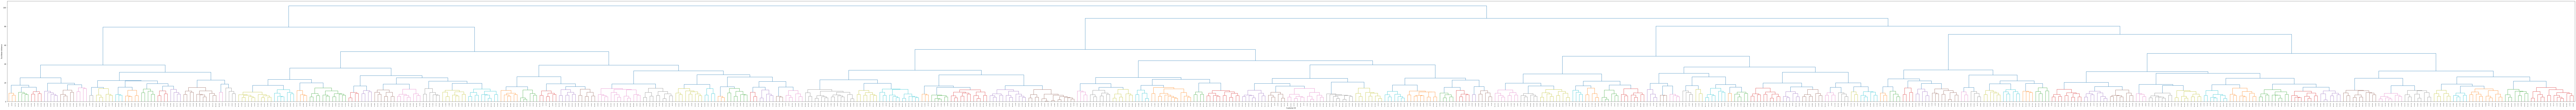

In [52]:
labels = df_cust_sales.iloc[:, 0].values
plt.figure(figsize=(300, 12))
row_dendr = dendrogram(row_clusters, labels=labels, color_threshold=distance_threshold)
plt.ylabel("Euclidean distance")
plt.xlabel("Customer ID")
plt.show()

In [49]:
# Use Agglomerative Clustering based on Threshold
from sklearn.cluster import AgglomerativeClustering

ac = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=distance_threshold,
    affinity="euclidean",
    linkage="ward",
)

hc_cluster = ac.fit_predict(df_for_pca.values)

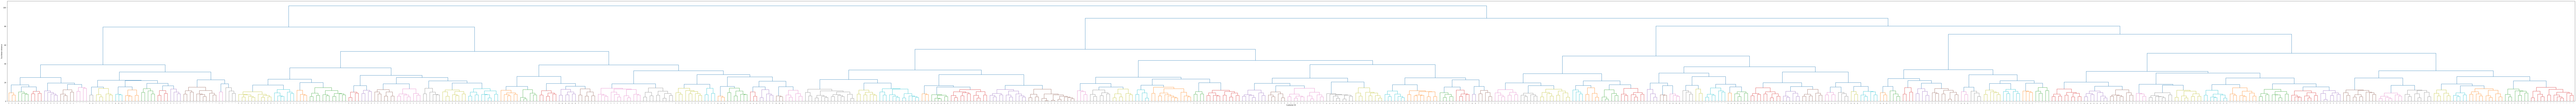

In [51]:
labels = hc_cluster
plt.figure(figsize=(300, 12))
row_dendr = dendrogram(row_clusters, labels=labels, color_threshold=distance_threshold)
plt.ylabel("Euclidean distance")
plt.xlabel("Customer ID")
plt.show()

In [30]:
len(hc_cluster)

793

In [31]:
# Joining details back

df_cluster = pd.concat(
    [pd.DataFrame(hc_cluster, columns=["Cluster"]), df_cust_sales], axis=1
)

In [32]:
df_cluster["Cluster"].nunique()

120

In [33]:
df_cluster["Cluster"].value_counts().to_frame()

,Cluster
44,16
37,15
17,14
1,14
2,13
...,...
49,3
102,2
118,2
113,2


In [34]:
# Cluster Heat Map Visualization
import seaborn as sns

df_plot_heatmap = df_cluster.groupby("Cluster").sum().applymap(lambda x: np.log(x + 1))
columns = list(df_plot_heatmap.sum(axis=0).sort_values(ascending=False).index)
df_plot_heatmap_sort = df_plot_heatmap[columns]

<AxesSubplot:ylabel='Cluster'>

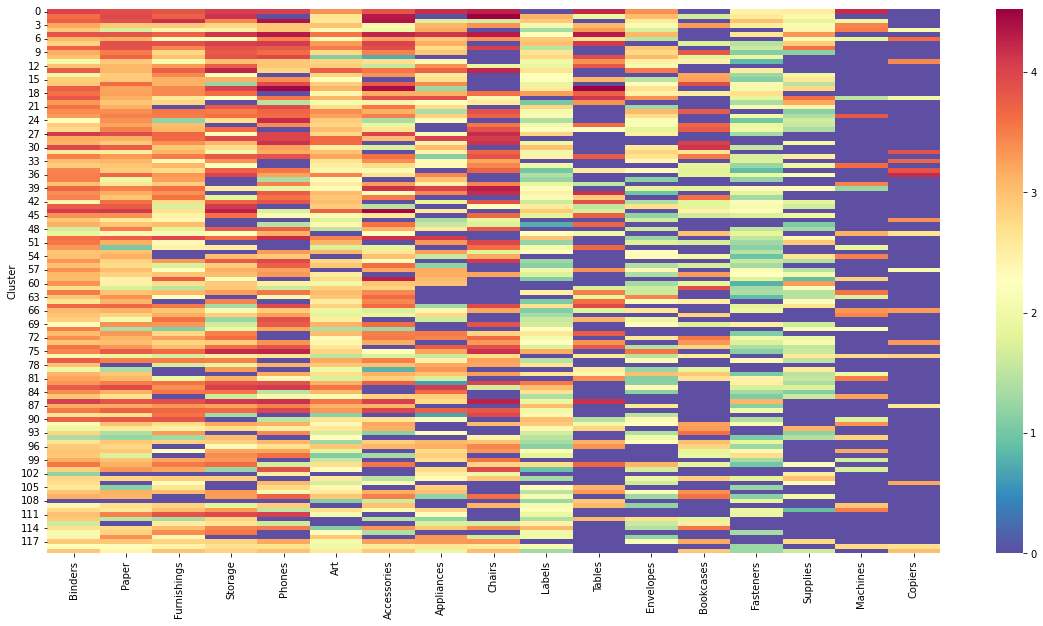

In [35]:
plt.figure(figsize=(20, 10))
sns.heatmap(df_plot_heatmap_sort, cmap="Spectral_r")

In [36]:
df_cluster_customer_count = (
    df_cluster[["Cluster", "Customer ID"]].groupby("Cluster").nunique().reset_index()
)
df_cluster_customer_count.columns = ["Cluster", "Count of Customers in Cluster"]

In [37]:
df_cluster_customer_count.head()

,Cluster,Count of Customers in Cluster
0,0,11
1,1,14
2,2,13
3,3,4
4,4,4


In [38]:
df_cluster_original_amount = df_key_fields.merge(
    df_cluster[["Cluster", "Customer ID"]], how="left", on="Customer ID"
)

In [39]:
df_cluster_original_amount.head()

,Customer ID,Sub-Category,Sales,Cluster
0,CG-12520,Bookcases,261.9600,26
1,CG-12520,Chairs,731.9400,26
2,DV-13045,Labels,14.6200,40
3,SO-20335,Tables,957.5775,42
4,SO-20335,Storage,22.3680,42


In [40]:
df_cluster_cat_count = (
    df_cluster_original_amount.groupby(["Cluster", "Sub-Category"])
    .agg({"Sales": "sum", "Customer ID": "nunique"})
    .reset_index()
)
df_cluster_cat_count.columns = [
    "Cluster",
    "Sub-Category",
    "Sales",
    "Count of Customers in Cluster SubCat",
]

In [41]:
df_cluster_cat_count.head()

,Cluster,Sub-Category,Sales,Count of Customers in Cluster SubCat
0,0,Accessories,2337.294,9
1,0,Appliances,5576.404,11
2,0,Art,346.120,8
3,0,Binders,8250.038,10
4,0,Chairs,7597.798,11


In [42]:
df_cluster_cat = df_cluster_cat_count.merge(
    df_cluster_customer_count, how="left", on="Cluster"
)

In [43]:
df_cluster_cat["Percent Customer in each SubCat"] = (
    df_cluster_cat["Count of Customers in Cluster SubCat"]
    / df_cluster_cat["Count of Customers in Cluster"]
)

In [44]:
df_cluster_cat.head()

,Cluster,Sub-Category,Sales,Count of Customers in Cluster SubCat,Count of Customers in Cluster,Percent Customer in each SubCat
0,0,Accessories,2337.294,9,11,0.818182
1,0,Appliances,5576.404,11,11,1.000000
2,0,Art,346.120,8,11,0.727273
3,0,Binders,8250.038,10,11,0.909091
4,0,Chairs,7597.798,11,11,1.000000


<AxesSubplot:>

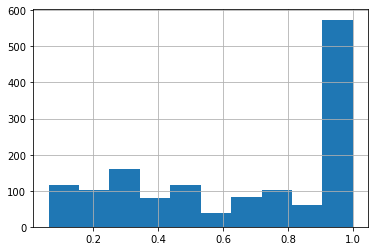

In [45]:
df_cluster_cat["Percent Customer in each SubCat"].hist()

In [46]:
# Set parameters for customers with similar purchases and get the top 5 categories based on amount spent
customer_coverage_percent = 0.8
top_n_cat = 5

In [47]:
mask_coverage = (
    df_cluster_cat["Percent Customer in each SubCat"] >= customer_coverage_percent
)
df_cluster_desc_gen = df_cluster_cat.loc[
    mask_coverage, ["Cluster", "Sub-Category", "Sales", "Count of Customers in Cluster"]
]
df_cluster_desc_gen.sort_values(
    by=["Cluster", "Sales"], ascending=[True, False], inplace=True
)

In [48]:
df_cluster_desc_gen[0:20]

,Cluster,Sub-Category,Sales,Count of Customers in Cluster
3,0,Binders,8250.038,11
8,0,Machines,7915.091,11
4,0,Chairs,7597.798,11
10,0,Phones,7187.104,11
13,0,Tables,6827.768,11
11,0,Storage,5848.230,11
1,0,Appliances,5576.404,11
0,0,Accessories,2337.294,11
7,0,Furnishings,1974.370,11
9,0,Paper,1238.758,11


In [49]:
set_cat = set(df_cluster_desc_gen["Cluster"])

In [50]:
list_cluster = []
list_desc = []

for item in set_cat:
    df_temp = (
        df_cluster_desc_gen[df_cluster_desc_gen["Cluster"] == item].reset_index().copy()
    )
    desc = "|".join(df_temp.loc[0 : top_n_cat - 1, "Sub-Category"].tolist())
    list_cluster.append(item)
    list_desc.append(desc)

In [51]:
df_cluster_desc = pd.DataFrame(
    {"Cluster": list_cluster, "Cluster Description": list_desc}
)

In [52]:
df_cluster_desc.head()

,Cluster,Cluster Description
0,0,Binders|Machines|Chairs|Phones|Tables
1,1,Chairs|Accessories|Storage|Paper|Binders
2,2,Accessories|Phones|Furnishings|Paper
3,3,Machines|Chairs|Bookcases|Binders|Appliances
4,4,Machines|Tables|Appliances|Binders


In [53]:
df_cluster_original_amount = df_key_fields.merge(
    df_cluster[["Cluster", "Customer ID"]], how="left", on="Customer ID"
)

In [54]:
df_cluster_original_amount.head()

,Customer ID,Sub-Category,Sales,Cluster
0,CG-12520,Bookcases,261.9600,26
1,CG-12520,Chairs,731.9400,26
2,DV-13045,Labels,14.6200,40
3,SO-20335,Tables,957.5775,42
4,SO-20335,Storage,22.3680,42


In [55]:
df_cluster_sum_amount = (
    df_cluster_original_amount[["Cluster", "Sales", "Customer ID"]]
    .groupby("Cluster")
    .agg({"Customer ID": "nunique", "Sales": "sum"})
    .reset_index()
)

In [56]:
df_cluster_sum_amount.columns = [
    "Cluster",
    "Count of Customers in Cluster",
    "Cluster Sales",
]

In [57]:
def two_sig_fig(x):
    div = 10 ** (np.floor(np.log10(x)) - 1)
    return (x // div) * div

In [58]:
df_cluster_sum_amount["Cluster Sales Round"] = (
    df_cluster_sum_amount["Cluster Sales"].apply(two_sig_fig).astype(int)
)

In [59]:
df_cluster_desc_sales = df_cluster_desc.merge(
    df_cluster_sum_amount, how="left", on=["Cluster"]
)

In [60]:
df_cluster_desc_sales.head()

,Cluster,Cluster Description,Count of Customers in Cluster,Cluster Sales,Cluster Sales Round
0,0,Binders|Machines|Chairs|Phones|Tables,11,55906.783,55000
1,1,Chairs|Accessories|Storage|Paper|Binders,14,29833.351,29000
2,2,Accessories|Phones|Furnishings|Paper,13,24272.831,24000
3,3,Machines|Chairs|Bookcases|Binders|Appliances,4,34489.906,34000
4,4,Machines|Tables|Appliances|Binders,4,33048.645,33000


In [61]:
df_cluster_desc_sales["Cluster Desc Value"] = (
    df_cluster_desc_sales["Cluster Description"]
    + "__"
    + df_cluster_desc_sales["Cluster Sales Round"].astype(str)
)

In [62]:
df_cluster_desc_sales.drop(columns=["Cluster Sales Round"], inplace=True)

In [63]:
df_cluster_desc_sales.sort_values(
    by=["Count of Customers in Cluster", "Cluster Sales"],
    ascending=[False, False],
    inplace=True,
)

In [64]:
df_cluster_desc_sales.reset_index(drop=True, inplace=True)

In [65]:
df_cluster_desc_sales["Group ID"] = df_cluster_desc_sales.index + 1

In [66]:
df_cluster_desc_sales.head()

,Cluster,Cluster Description,Count of Customers in Cluster,Cluster Sales,Cluster Desc Value,Group ID
0,44,Accessories|Storage|Binders|Paper|Art,16,16138.809,Accessories|Storage|Binders|Paper|Art__16000,1
1,17,Tables|Accessories|Phones|Storage,14,38989.639,Tables|Accessories|Phones|Storage__38000,2
2,1,Chairs|Accessories|Storage|Paper|Binders,14,29833.351,Chairs|Accessories|Storage|Paper|Binders__29000,3
3,2,Accessories|Phones|Furnishings|Paper,13,24272.831,Accessories|Phones|Furnishings|Paper__24000,4
4,59,Accessories,13,11010.415,Accessories__11000,5


In [67]:
mask = df_cluster_desc_sales["Cluster Description"].isna()
df_cluster_desc_sales.loc[mask, "Group ID"] = -1

In [68]:
df_cluster_final = df_cluster[["Cluster", "Customer ID"]].merge(
    df_cluster_desc_sales, how="left", on="Cluster"
)

In [69]:
assert (
    df_cluster_final.shape[0] == df_cust_sales.shape[0]
), "The number of rows for customers should be the same"

In [70]:
df_cluster_final.head()

,Cluster,Customer ID,Cluster Description,Count of Customers in Cluster,Cluster Sales,Cluster Desc Value,Group ID
0,60,AA-10315,Supplies|Binders|Appliances|Storage|Accessories,4.0,13138.3210,Supplies|Binders|Appliances|Storage|Accessorie...,99.0
1,2,AA-10375,Accessories|Phones|Furnishings|Paper,13.0,24272.8310,Accessories|Phones|Furnishings|Paper__24000,4.0
2,7,AA-10480,Phones|Tables|Storage|Accessories|Paper,10.0,26257.8980,Phones|Tables|Storage|Accessories|Paper__26000,17.0
3,22,AA-10645,Chairs|Bookcases|Phones|Storage|Furnishings,7.0,24793.1025,Chairs|Bookcases|Phones|Storage|Furnishings__2...,43.0
4,29,AB-10015,Phones|Chairs|Bookcases|Art,10.0,23205.7794,Phones|Chairs|Bookcases|Art__23000,19.0


In [71]:
df_data_w_cluster = df_raw.merge(df_cluster_final, how="left", on="Customer ID")

In [72]:
df_data_w_cluster.shape

(9994, 27)

In [73]:
df_data_w_cluster.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Sales,Quantity,Discount,Profit,Cluster,Cluster Description,Count of Customers in Cluster,Cluster Sales,Cluster Desc Value,Group ID
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,261.9600,2,0.00,41.9136,26,Chairs|Bookcases|Storage|Paper,8.0,11637.5500,Chairs|Bookcases|Storage|Paper__11000,36.0
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,731.9400,3,0.00,219.5820,26,Chairs|Bookcases|Storage|Paper,8.0,11637.5500,Chairs|Bookcases|Storage|Paper__11000,36.0
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,14.6200,2,0.00,6.8714,40,Chairs|Tables|Phones|Art,10.0,20829.0090,Chairs|Tables|Phones|Art__20000,20.0
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,957.5775,5,0.45,-383.0310,42,Phones|Chairs|Tables|Storage|Paper,8.0,18415.9575,Phones|Chairs|Tables|Storage|Paper__18000,34.0
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,22.3680,2,0.20,2.5164,42,Phones|Chairs|Tables|Storage|Paper,8.0,18415.9575,Phones|Chairs|Tables|Storage|Paper__18000,34.0
